# Import Libraries

In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, r2_score, classification_report
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

import math

from rfpimp import *

from collections import defaultdict

The scikit-learn version is 0.21.3.


# Import Data

In [2]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/Master_Data_20200324.xlsx"
data = pd.read_excel(file)
df_master = pd.DataFrame(data).set_index('FIPS')

file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/train_set_20200206.xlsx"
data = pd.read_excel(file)
train_set = pd.DataFrame(data).set_index('FIPS')

file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/test_set_20200206.xlsx"
data = pd.read_excel(file)
test_set = pd.DataFrame(data).set_index('FIPS')

file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/F3_Mean.xlsx"
data = pd.read_excel(file)
df_damage_mean = pd.DataFrame(data).set_index('Comm_Code')

file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/F3_Max.xlsx"
data = pd.read_excel(file)
df_damage_max = pd.DataFrame(data).set_index('Comm_Code')

In [3]:
df_master.describe()

,PropSFHA,AveDepth,PropFA,MaxDepth,AveLS,HurTrack,PeakGust,MaxSusWinds,PropSC,StrVI,SeVI,CDCVuln,DI1,DI2,DI3
count,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,881.000000,775.000000
mean,0.173662,0.982619,0.058447,2.634887,1.104161,0.223594,52.697914,41.591950,0.033937,0.000533,0.020068,0.500642,0.032037,0.031664,0.036460
std,0.260877,1.529905,0.159692,4.692369,0.412690,0.126709,8.664104,6.932878,0.090211,3.766862,5.450390,0.289171,0.035476,0.033720,0.035652
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.590000,19.220000,0.000000,-13.150000,-23.740000,0.000000,0.000000,0.000000,0.000234
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.130000,45.150000,35.320000,0.000000,-2.635000,-3.087500,0.250575,0.006897,0.006873,0.011975
50%,0.040000,0.000000,0.000000,0.000000,1.000000,0.220000,55.880000,44.260000,0.003223,-0.190000,0.630000,0.501150,0.022014,0.021994,0.026678
75%,0.220000,1.760000,0.020000,4.502500,1.290000,0.290000,59.900000,47.390000,0.023284,2.417500,3.697500,0.750525,0.044725,0.044662,0.048725
max,1.000000,9.730000,1.000000,61.940000,3.000000,0.920000,65.710000,54.540000,0.977416,16.520000,15.220000,1.000000,0.360825,0.229145,0.360825


# Explore Data

In [4]:
def histogram(feature_label, x_label, save_0_1):
    x = df_master[feature_label]
    plt.hist(x, 10,facecolor='grey', edgecolor='black')

    plt.rcParams.update({'font.size': 14})

    plt.xlabel(x_label, fontsize = 14)
    plt.ylabel('Count', fontsize = 14)
    plt.ylim(0,1000)
    
    if save_0_1 == 0:
        plt.savefig('histogram_PropSC.pdf', dpi=600, bbox_inches = "tight")

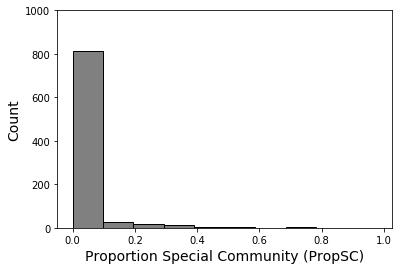

In [5]:
histogram('PropSC', 'Proportion Special Community (PropSC)', 1)

In [6]:
def boxplot(feature_label, x_label, save_0_1):
    fig, ax = plt.subplots(1,1,figsize=(3, 6))
    ax = df_master[feature_label].plot(kind='box',
             color=dict(boxes='black', whiskers='black', medians='black', caps='black'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=True, grid=True, rot=0)

    ax.set_ylabel("Proportion of Damaged Structures", fontsize = 18)
    ax.set_xlabel(x_label, fontsize=18)
    plt.xticks([0], ['Damage'], fontsize=50)
    plt.ylim(0,0.4)
    ax.tick_params(labelsize=15)

    if save_0_1 == 0:
        plt.savefig('boxplot.pdf', dpi=600, bbox_inches = "tight")

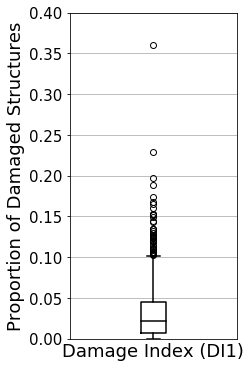

In [7]:
boxplot('DI1', 'Damage Index (DI1)', 1)

In [8]:

from numpy import percentile

# calculate interquartile range
q25, q75 = percentile(df_master['DI1'], 25), percentile(df_master['DI1'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in df_master['DI1'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))


Percentiles: 25th=0.007, 75th=0.045, IQR=0.038
Identified outliers: 46


In [8]:
def damage_analysis(df_max_mean, save_0_1):
    ax = df_max_mean.sort_values('DI1', ascending=False).plot.bar('label','DI1', zorder=3,
                                                                                color='black', 
                                                                                legend = False)
    plt.title("", fontsize = 25, fontdict={'horizontalalignment': 'center'})
    plt.ylabel('Mean DI1', fontsize = 18)
    plt.xlabel(' ')
    plt.ylim(0,0.14)
    plt.xticks(fontsize = 18, rotation = 45, ha='right')
    plt.yticks(fontsize = 14)
    
    if save_0_1 == 0:
        plt.savefig('damage_mean.pdf', dpi=600, bbox_inches = "tight")

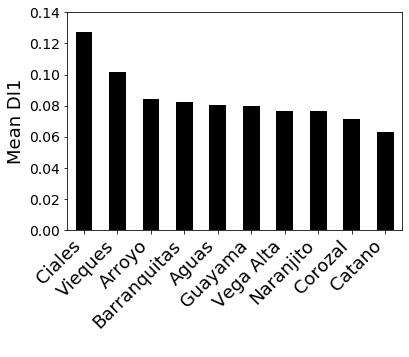

In [9]:
damage_analysis(df_damage_mean, 1)

In [10]:
df_master.corr(method='spearman', min_periods=1).round(2)

,PropSFHA,AveDepth,PropFA,MaxDepth,AveLS,HurTrack,PeakGust,MaxSusWinds,PropSC,StrVI,SeVI,CDCVuln,DI1,DI2,DI3
PropSFHA,1.00,0.28,0.41,0.28,-0.26,0.25,-0.04,-0.02,0.04,-0.11,-0.06,0.05,0.03,0.02,0.02
AveDepth,0.28,1.00,0.82,0.98,0.14,-0.17,-0.19,-0.18,0.03,0.24,-0.00,0.01,0.17,0.17,0.19
PropFA,0.41,0.82,1.00,0.84,-0.02,-0.11,-0.13,-0.11,0.01,0.14,0.01,0.01,0.13,0.13,0.13
MaxDepth,0.28,0.98,0.84,1.00,0.12,-0.18,-0.20,-0.19,0.02,0.25,0.00,0.01,0.17,0.17,0.20
AveLS,-0.26,0.14,-0.02,0.12,1.00,-0.22,-0.24,-0.26,0.06,0.24,0.02,0.06,0.06,0.06,0.12
HurTrack,0.25,-0.17,-0.11,-0.18,-0.22,1.00,-0.18,-0.17,0.04,-0.23,-0.10,0.01,-0.22,-0.22,-0.24
PeakGust,-0.04,-0.19,-0.13,-0.20,-0.24,-0.18,1.00,0.99,-0.09,-0.39,0.10,-0.24,-0.01,-0.01,-0.08
MaxSusWinds,-0.02,-0.18,-0.11,-0.19,-0.26,-0.17,0.99,1.00,-0.09,-0.40,0.09,-0.24,0.01,0.01,-0.06
PropSC,0.04,0.03,0.01,0.02,0.06,0.04,-0.09,-0.09,1.00,0.20,-0.21,0.30,0.21,0.21,0.26
StrVI,-0.11,0.24,0.14,0.25,0.24,-0.23,-0.39,-0.40,0.20,1.00,-0.13,0.32,0.23,0.23,0.31


# Partition Data into Training and Evaluation Sets

In [4]:
def partition_data(df, target_str):
    y = df[target_str]
    df_x = df.drop(target_str, axis = 1)
    return y, df_x

In [5]:
def choose_damage_index_for_partition(DI, train_set, test_set, df_master):
    
    if DI == 'DI1':
        target_str = 'y_train'
        y_train, x_train = partition_data(train_set, target_str)

        target_str = 'y_test'
        y_test, x_test = partition_data(test_set, target_str)
        
        return y_train, x_train, y_test, x_test
        
    if DI == 'DI2':
        # Get names of indexes for which column Age has value 30
        indexNames = train_set[train_set.y_train > 0.25].index
 
        # Delete these row indexes from dataFrame
        train_set.drop(indexNames , inplace=True)
        #train_set.describe()
        
        target_str = 'y_train'
        y_train, x_train = partition_data(train_set, target_str)

        target_str = 'y_test'
        y_test, x_test = partition_data(test_set, target_str)
        
        return y_train, x_train, y_test, x_test
        
    if DI == 'DI3':
        test_set = test_set.drop(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
        'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot', 'y_test'], axis=1)
        train_set = train_set.drop(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
        'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot', 'y_train'], axis=1)

        test_set = test_set.merge(df_master, right_index=True, left_index=True, how='left')
        train_set=train_set.merge(df_master, right_index=True, left_index=True, how='left')

        test_set.dropna(axis=0, subset = [DI], inplace=True)
        train_set.dropna(axis=0, subset = [DI],inplace=True)
        
        test_set = test_set.drop(['MaxSusWinds', 'MaxDepth'], axis=1)
        train_set = train_set.drop(['MaxSusWinds', 'MaxDepth'], axis=1)

        y_train = train_set[DI]
        y_test = test_set[DI]

        x_train = train_set.drop([DI, 'DI1', 'DI2'], axis = 1)
        x_test = test_set.drop([DI, 'DI1', 'DI2'], axis = 1)
        
        return y_train, x_train, y_test, x_test

In [6]:
#refresh before each new run
y_train, x_train, y_test, x_test = choose_damage_index_for_partition('DI1', train_set, test_set, df_master)

# Tune the Models

## Random Forest

### DI1

In [7]:
tune_reg_3BB=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=19,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
Model=tune_reg_3BB.fit(x_train, y_train)
print(Model.score(x_test, y_test))
print(Model.score(x_train, y_train))

0.291910621399
0.886152970675


### DI2

In [7]:
tune_reg_3B=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2300, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
Model=tune_reg_3B.fit(x_train, y_train)
print(Model.score(x_test, y_test))
print(Model.score(x_train, y_train))

0.316594322789
0.8939781815


### DI3

In [12]:
tune_reg_2 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features=1, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
Model=tune_reg_2.fit(x_train, y_train)
print(Model.score(x_test, y_test))
print(Model.score(x_train, y_train))

0.263225217634
0.893299617441


In [ ]:
tune_reg_2 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features=1, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
OPT2=tune_reg_2.fit(x_train, y_train)
print(OPT2.score(x_test, y_test))
print(OPT2.score(x_train, y_train))

## Stochastic Gradient Boosting Trees

### DI1

In [7]:
IDEAL8 = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.12,
                                max_depth = 13,
                                max_features=4,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=100,
                                subsample = 0.9,
                                random_state=42)
                                         

Model = IDEAL8.fit(x_train, y_train)

print(Model.score(x_test, y_test))
print(Model.score(x_train, y_train))

0.331215534084
0.712316613124


### DI2

In [7]:
IDEAL3B = GradientBoostingRegressor(loss = 'lad',
                                        learning_rate=0.09, 
                                        n_estimators=500,
                                        max_depth=11, 
                                        min_samples_split=15,
                                        min_samples_leaf=3, 
                                        subsample=0.9, 
                                        random_state=42,
                                        max_features=3)
Model = IDEAL3B.fit(x_train, y_train)

print(Model.score(x_test, y_test))
print(Model.score(x_train, y_train))

0.369636531148
0.851226586043


### DI3

In [17]:
# gbrt = GradientBoostingRegressor(loss = 'lad',
#                                 learning_rate=0.085,
#                                 max_depth = 13,
#                                 max_features=6,
#                                 min_samples_leaf= 4,
#                                 min_samples_split=16,
#                                 n_estimators=200,
#                                 subsample = 0.8,
#                                 random_state=42)

# Model = gbrt.fit(x_train, y_train)

# print(IDEAL4AA.score(x_test, y_test))
# print(IDEAL4AA.score(x_train, y_train))

0.293140342837
0.767037199911


In [7]:
gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 12,
                                max_features=5,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=102,
                                subsample = 0.8,
                                random_state=42)

Model = gbrt.fit(x_train, y_train)

print(Model.score(x_test, y_test))
print(Model.score(x_train, y_train))

0.364056593428
0.69966010889


# Evaluate Models

In [8]:
def predict(model, x_train, x_test):   
    pred_test = model.predict(x_test)
    pred_train = model.predict(x_train)
    
    return pred_train, pred_test

In [9]:
pred_train, pred_test = predict(Model, x_train, x_test)

In [10]:
def evaluate_regression(pred_train, pred_test, y_train, y_test):
    r_train = r2_score(y_train, pred_train)
    print('The training r-squared score is {}'.format(r_train))
    r_test = r2_score(y_test, pred_test)
    print('The testing r-squared score is {}'.format(r_test))
    meanabserrors_train = np.mean(abs(pred_train - y_train))
    #print('The training mean absolute error is {}'.format(meanabserrors_train))
    meanabserrors_test = np.mean(abs(pred_test - y_test))
    print('The testing mean absolute error is {}'.format(meanabserrors_test))
    rmse = math.sqrt(mean_squared_error(y_test, pred_test))
    #print('The root mean square error is {}'.format(rmse))
    mse = mean_squared_error(y_test, pred_test)
    #print('The mean square error is {}'.format(mse))
    errors = y_test- pred_test
    errors2 = y_train - pred_train
#true - predicted
    meanerror = np.mean(errors)
    trainmeanerror = np.mean(errors2)
    print('The testing mean error is {}'.format(meanerror))
    #print('The training mean error is {}'.format(trainmeanerror))
    return errors

In [11]:
errors = evaluate_regression(pred_train, pred_test, y_train, y_test)

The training r-squared score is 0.7123166131238429
The testing r-squared score is 0.33121553408433624
The testing mean absolute error is 0.018487165541671433
The testing mean error is 0.0025516385685516317


In [12]:
def plot_errors(errors):
    plt.hist(errors, 30, histtype='bar', ec='white', color='Black')
    plt.xlabel('Error', fontsize = 20)
    plt.ylabel('Count', fontsize = 20)
    plt.title('')
    plt.grid(False)
    plt.axvline(x=-0.03, color='grey')
    plt.axvline(x=-0.01, color='grey')
    plt.axvline(x=0.01, color='grey')
    plt.axvline(x=0.03, color='grey')
    plt.tick_params(axis='both', which='major', labelsize=18)
    #plt.show()
    #plt.savefig('Hisogram_Errors_2.png', dpi=600, bbox_inches = "tight")


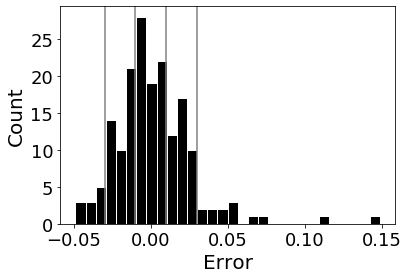

In [19]:
plot_errors(errors)

# Plot Predictions

In [14]:
def plot_predictions(y_test, pred, Title):
    df_predictions = pd.DataFrame(y_test)
    df_predictions['Pred'] = pred
    X = df_predictions.iloc[:, 0].values.reshape(-1, 1)
    Y = df_predictions.iloc[:, 1].values.reshape(-1, 1)
    fig, ax = plt.subplots()
    
    ax.scatter(X, Y, color='black')
    plt.legend(fontsize=15)
    
    line = mlines.Line2D([0, 1], [0, 1], color='grey')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    
    ax.set_xlabel(ax.get_xlabel(), fontsize = 18)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(False)
    plt.xlabel("True Damage Index")
    plt.ylabel("Predicted Damage Index")
    plt.xlim(0,0.4)
    plt.ylim(0,0.4)
    #plt.title('Model Evaluation -' +  Title, fontsize = 20)
    plt.savefig('train_SGBT_DI1.pdf', dpi=600, bbox_inches = "tight")
    plt.show()

No handles with labels found to put in legend.


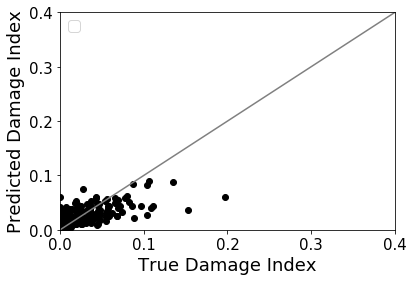

In [13]:
plt.rcParams["figure.figsize"] = (6,4)
Title = ''
plot_predictions(y_test, pred_test, Title)

No handles with labels found to put in legend.


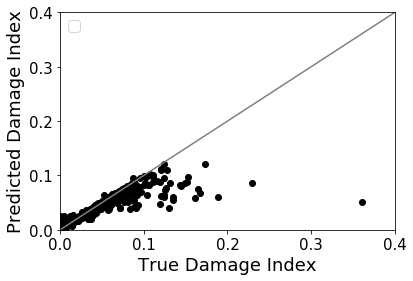

In [15]:
Title = ''
plot_predictions(y_train, pred_train, Title)

# Feature Importances

## Default

In [20]:
def calc_gini_importances(x_train, model):
    importances = model.feature_importances_
    importances_df = pd.DataFrame(importances, x_train.columns,
                                  columns=['Importance'])
    #.sort_values('Importance', ascending=False)
    importances_df.reset_index(inplace=True)
    importances_df.rename(columns={'index':'Feature'}, inplace=True)
    return importances_df

In [33]:
df_gini_importances = calc_gini_importances(x_train, Model)
#df_gini_importances['Labels'] = ['Special Flood Hazard Area', 'Average Depth', 'Flooded Area', 'Average Landslide', 'Hurricane Track', 'Peak Gust', 'Special Community', 'Structural Vulnerability', 'Socioeconomic Vulnerability', 'CDC Vulnerability']
df_gini_importances['Labels'] = ['PropSFHA', 'AveDepth', 'PropFA', 'AveLS', 'HurTrack', 'PeakGust', 'PropSC', 'StrVI', 'SeVI', 'CDCVuln']

In [40]:
def plot_importance(df_gini_importances):
    df_gini_importances.sort_values('Importance', ascending=False).plot.bar('Labels',
                                                                            'Importance', 
                                                                            color='black', 
                                                                            legend = False, zorder=3)
    plt.title("", fontsize = 25)
    plt.ylabel('Mean Decrease in MSE', fontsize = 18)
    plt.xlabel('')
    plt.xticks(fontsize = 18, rotation = 45, ha='right')
    plt.yticks(fontsize = 18)
    plt.ylim(0,0.15)
    #plt.grid(True)
    #plt.savefig('SGBT_DI2_Presentation.png', dpi=600, bbox_inches = "tight")

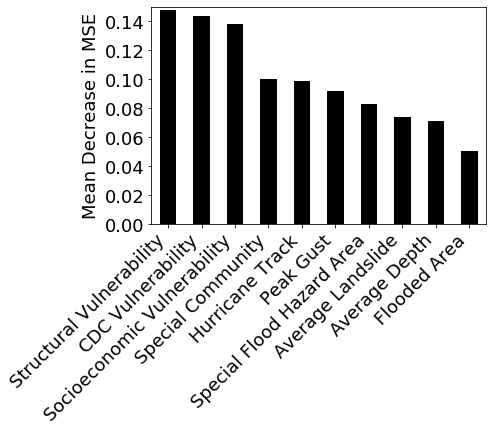

In [41]:
plot_importance(df_gini_importances)

## Permutation

In [42]:
def calc_permutation_imp(model,x,y, features):
    baseline = model.score(x,y)
    imp = []
    for col in x.columns:
        save = x[col].copy()
        x[col]=np.random.permutation(x[col])
        m = model.score(x,y)
        x[col] = save
        imp.append(((baseline - m)/baseline)*100)
        
    Results = np.array(imp)
    Results = pd.DataFrame(Results)
    Results['Feature'] = features
    Results.rename(columns = {0:'Importance'}, inplace=True)
    
    return Results

In [45]:
features = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack',
       'PeakGust', 'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot']
# features = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack',
#        'PeakGust', 'SpecCom',  'CDC_Tot']
df_perm_imp = calc_permutation_imp(Model,x_train,y_train, features)
df_perm_imp['Labels'] = ['Special Flood Hazard Area', 'Average Depth', 'Flooded Area', 'Average Landslide', 'Hurricane Track', 'Peak Gust', 'Special Community', 'Structural Vulnerability', 'Socioeconomic Vulnerability', 'CDC Vulnerability']
#df_perm_imp['Labels'] = ['PropSFHA', 'AveDepth', 'PropFA', 'AveLS', 'HurTrack', 'PeakGust', 'PropSC', 'StrVI', 'SeVI', 'CDCVuln']

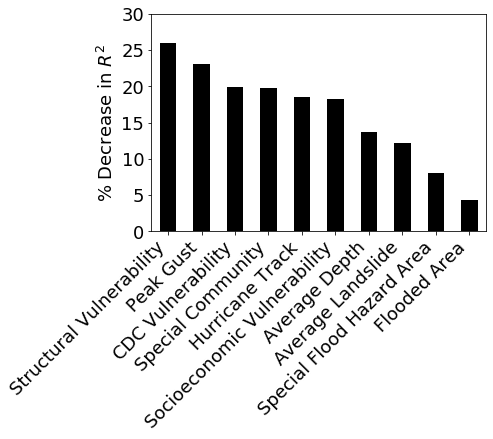

In [52]:
df_perm_imp.sort_values('Importance', ascending=False).plot.bar('Labels',
                                                                            'Importance', 
                                                                            color='black', 
                                                                            legend = False, zorder=3)
plt.title("", fontsize = 25)
plt.ylabel('% Decrease in ' + r'$R^2$', fontsize = 18)
plt.xlabel('')
plt.xticks(fontsize = 18, rotation = 45, ha='right')
plt.yticks(fontsize = 18)
plt.ylim(0,30)
#plt.grid(True)
#plt.savefig('SGBT_DI3_presentation.png', dpi=600, bbox_inches = "tight")

## Group Permutation

In [54]:
# features = [['PeakGust', 'HurTrack'],
#            ['StrVI', 'PropSC', 'SeVI', 'CDCVuln'],
#            ['AveDepth', 'PropFA', 'PropSFHA'],
#            ['AveLS']]
features = [['PeakGust', 'HurTrack'],
           ['STRVI_1', 'SpecCom', 'SEVI_1', 'CDC_Tot'],
           ['AveDepth', 'PropDG', 'PropSFHA'],
           ['AveLS']]
I = importances(Model, x_train,y_train, features=features)


In [55]:
I

,Importance
Feature,
STRVI_1\nSpecCom\nSEVI_1\nCDC_Tot,0.698461
PeakGust\nHurTrack,0.444114
AveDepth\nPropDG\nPropSFHA,0.214873
AveLS,0.111013


In [56]:
I.reset_index(inplace=True)
I.drop(['Feature'], axis=1)
I['Feature2'] = ['Vulnerability', 'Wind', 'Flood', 'Landslide']
base_score = Model.score(x_train, y_train)
I['basescore'] = base_score
I['Perc_Dec'] = ((I['Importance']) / I['basescore']) * 100

In [57]:
I

,Feature,Importance,Feature2,basescore,Perc_Dec
0,STRVI_1\nSpecCom\nSEVI_1\nCDC_Tot,0.698461,Vulnerability,0.851227,82.053456
1,PeakGust\nHurTrack,0.444114,Wind,0.851227,52.173440
2,AveDepth\nPropDG\nPropSFHA,0.214873,Flood,0.851227,25.242731
3,AveLS,0.111013,Landslide,0.851227,13.041579


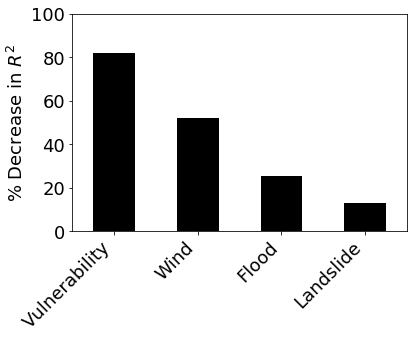

In [59]:
I.sort_values('Perc_Dec', ascending=False).plot.bar('Feature2',
                                                                            'Perc_Dec', 
                                                                            color='black', 
                                                                            legend = False, zorder=3)
plt.title("", fontsize = 25)
plt.ylabel('% Decrease in ' + r'$R^2$', fontsize = 18)
plt.xlabel('')
plt.xticks(fontsize = 18, rotation = 45, ha='right')
#plt.xticks(np.arange(min(0), max(100), 20))
plt.yticks(fontsize = 18)
plt.ylim(0,100)
#plt.grid(True)
#plt.savefig('SGBT_DI2_group_presentation.png', dpi=600, bbox_inches = "tight")

## Partial Dependence

In [78]:
def plot_part_depend(model, x_train, feature_list, feature_names):
    with plt.rc_context({'legend.fontsize': 'x-large',
              'figure.figsize': (20, 20),
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}):
        #plt.subplots(nrows=3,ncols=3, sharey=True)
        plot_partial_dependence(model, 
                                x_train, 
                                feature_list, 
                                feature_names = feature_names, 
                                grid_resolution=10, 
                                n_cols=4,
                                method='brute', line_kw={"c": "black"}
                               ) 
        fig = plt.gcf()
        #fig.suptitle('test title', fontsize=20, y = .75)
        fig.subplots_adjust(hspace=0.3)
        #ax.set_ylabel('common ylabel')
        #fig.axes.get_yaxis().set_visible(False)
        #fig.subplots_adjust(sharey='row')
        #fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
        plt.savefig('SGBT_DI2_presentation.png', dpi=200, bbox_inches = "tight")

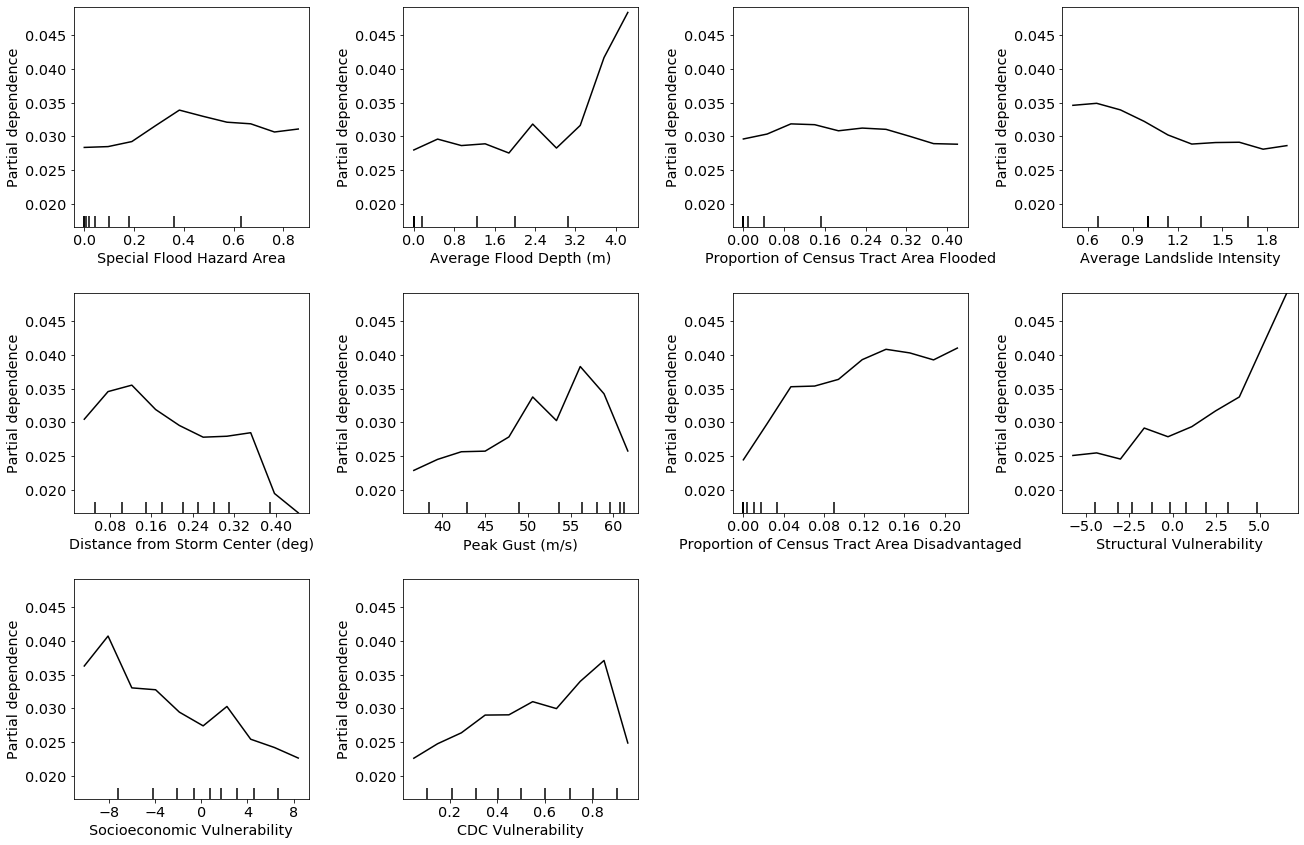

In [79]:
feature_list=[0,1,2,3,4,5,6,7,8,9]
feature_names= ['Special Flood Hazard Area', 'Average Flood Depth (m)', 'Proportion of Census Tract Area Flooded', 'Average Landslide Intensity', 'Distance from Storm Center (deg)', 'Peak Gust (m/s)', 'Proportion of Census Tract Area Disadvantaged', 'Structural Vulnerability', 'Socioeconomic Vulnerability', 'CDC Vulnerability']
#feature_names=['PropSFHA', 'AveDepth', 'PropFA', 'AveLS', 'HurTrack', 'PeakGust', 'PropSC', 'StrVI', 'SeVI', 'CDCVuln']
plot_part_depend(Model, x_train, feature_list, feature_names)